# Making Transformers Efficient in Production

Transformers can be trained to be very accurate, but sometimes that is not enough. A model is not useful if it is too slow or too large to be run. So what can be done to create a fast, compact and yet highly accurate transformer model?

In 2019, Roblox faced this scenario. Their experience can be found in their blog post on medium.com.<br>
<a href="https://medium.com/@quocnle/how-we-scaled-bert-to-serve-1-billion-daily-requests-on-cpus-d99be090db26#:~:text=To%20scale%20to%20more%20than,workers%20horizontally%20across%20many%20servers.">How We Scaled Bert To Serve 1+ Billion Daily Requests on CPUs</a>

In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import pipeline
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The model we will use is a BERT model that has been fine-tuned to classify the intent expressed in text. The BERT model is available on Huggingface.co

Let's see how it works.

In [3]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""

In [4]:
bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
BERTpipe = pipeline("text-classification", model=bert_ckpt, device=device)

In [5]:
# Let's also build a BERT pipeline that isn't on the GPU for comparison later
BERTpipe_cpu = pipeline("text-classification", model=bert_ckpt)

In [6]:
BERTpipe(query)

[{'label': 'car_rental', 'score': 0.549003541469574}]

### Let's build up our performance benchmark class
We will use this class throughout the notebook to gather statistics about each of our methods

In [7]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        # We'll define this later
        pass

    def compute_size(self):
        # We'll define this later
        pass

    def time_pipeline(self):
        # We'll define this later
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

#### compute_accuracy - for the dataset and model in the class, compute accuracy

In [8]:
from datasets import load_metric

accuracy_score = load_metric("accuracy")

def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

<ipython-input-8-a31c3b22739c>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")


#### compute_size takes the model and saves it temporarily to disk and checks the size of the file

In [9]:
from pathlib import Path

def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

#### time_pipeline takes a simple query and runs it 100 times to get the average time and standard deviation
Use the perf_counter to get a more accurate time in seconds. Multiply by 1000 to get milliseconds

In [10]:
from time import perf_counter

def time_pipeline(self, query="What is the pin number for my account?"):
    """This overrides the PerformanceBenchmark.time_pipeline() method"""
    latencies = []
    # Warmup the caches etc.
    for _ in range(10):
        _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

#### We will also need a function to plot our results

In [11]:
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline - CPU"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

### Now let's load up the data
The clinc_oos dataset covers 150 intent classes in over 10 domains. It includes queries that are out-of-scope (OOS), i.e. queries that do not fall in any of the supported intents. 

In [12]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

Found cached dataset clinc_oos (/var/snell_home/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)


  0%|          | 0/3 [00:00<?, ?it/s]

#### What does it look like?

In [13]:
clinc

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

In [14]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [15]:
# What is the intent of the sample in text form?
intents = clinc["test"].features["intent"]
intents.int2str(sample['intent'])

'transfer'

In [16]:
# How is it distributed?
df = pd.DataFrame(clinc['train'])
df['intent'].value_counts()

42     250
89     100
2      100
21     100
137    100
      ... 
119    100
98     100
30     100
132    100
51     100
Name: intent, Length: 151, dtype: int64

In [17]:
# What happens when we run in through our pipeline?
BERTpipe(sample['text'])

[{'label': 'transfer', 'score': 0.5653557181358337}]

In [18]:
# What is intent 89?
intents.int2str(89)

'pin_change'

In [19]:
# What is intent 42?
intents.int2str(42)

'oos'

### Now let's use our performance benchmark class and see how our pipeline does.

In [20]:
%%time
optim_type = "BERT baseline"
pb = PerformanceBenchmark(BERTpipe, clinc['test'], optim_type=optim_type)
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.15


/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Average latency (ms) - 6.18 +\- 0.16
Accuracy on test set - 0.867
CPU times: user 34.9 s, sys: 249 ms, total: 35.2 s
Wall time: 35.2 s


In [21]:
%%time
optim_type = "BERT baseline - CPU"
pb = PerformanceBenchmark(BERTpipe_cpu, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 418.15
Average latency (ms) - 15.94 +\- 0.63
Accuracy on test set - 0.867
CPU times: user 14min 52s, sys: 1.49 s, total: 14min 54s
Wall time: 1min 29s


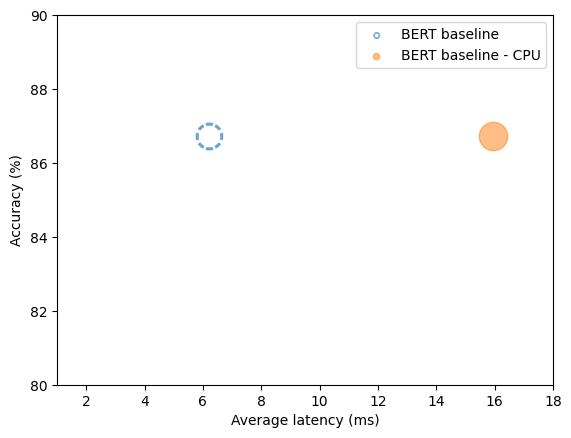

In [22]:
# Plot the latency vs accuracy with the radius being the size of the model on dis
plot_metrics(perf_metrics, "BERT baseline")

# How can we make a smaller and faster model? - Distillation

Distillation is the process of training a smaller model (student) to act like another model (teacher)

<img alt="Knowledge distillation" caption="The knowledge distillation process" src="notebooks/images/chapter08_kd.png" id="kd"/> 

$L_{KD}$ is the Kullback-Leibler(KL) divergence which measures the difference between two probability distributions <br>
We compare the full output of the teacher model with the output of the student model

$$D_{KL}(p,q) = \sum \limits _{i} p_i(x)log \frac{p_i(x)}{q_i(x)}$$

$$L_{KD} = T^2D_{KL}$$

And now the loss for the student is:

$$L_{Student} = \alpha L_{CE} + (1 - \alpha)L_{KD}$$

where $L_{CE}$ is the normal Cross Entropy loss of the student when comparing to the correct output and <br>
T is the smoothing 'temperature' for the Softmax output

Now to implement knowledge distillation we need to add a few things to the Trainer base class:

<ul>
<li>The new hyperparameters $\alpha$  and T, which control the relative weight of the distillation loss and how much the probability distribution of the labels should be smoothed

<li>The fine-tuned teacher model, which in our case is BERT-base

<li>A new loss function that combines the cross-entropy loss with the knowledge distillation loss
</ul>
Adding the new hyperparameters is quite simple, since we just need to subclass TrainingArguments and include them as new attributes:

In [23]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

For the trainer itself, we need a new loss function. The way to implement this is by subclassing Trainer and overriding the compute_loss() method to include the knowledge distillation loss term $L_{KD}$:

In [24]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

In [25]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

## First set up the Teacher

In [26]:
from transformers import AutoModelForSequenceClassification

num_labels = intents.num_classes

In [27]:
# Pull the pretrained model from the textbook from huggingface
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

## Set up the student from a base instantiation of distilbert

In [28]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

# Tokenize the dataset using the student_tokenizer
def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

# tokenize - after tokenization, we no longer need the text. We feed the tokens to the model
clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Loading cached processed dataset at /var/snell_home/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1/cache-88e55836c84bca2f.arrow
Loading cached processed dataset at /var/snell_home/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1/cache-e98e92af6fcb170f.arrow
Loading cached processed dataset at /var/snell_home/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1/cache-ab8d419ed3e377c8.arrow


One other thing we need to do is provide the student model with the mappings between each intent and label ID. These mappings can be obtained from our BERT-base model that we downloaded in the pipeline:

In [29]:
id2label = BERTpipe.model.config.id2label
label2id = BERTpipe.model.config.label2id

In [30]:
from transformers import AutoConfig

student_config = (AutoConfig.from_pretrained(student_ckpt, num_labels=num_labels,
                                             id2label=id2label, label2id=label2id))

In [31]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
            output_dir=finetuned_ckpt, 
            evaluation_strategy = "epoch",
            num_train_epochs=7, 
            learning_rate=2e-5,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size, 
            alpha=1, 
            weight_decay=0.01,
            push_to_hub=False)

In [32]:
# Setup the student initially as an AutoModelForSequenceClassification with the base student

def student_init():
    return (AutoModelForSequenceClassification.from_pretrained(student_ckpt, config=student_config).to(device))

In [33]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
                                         teacher_model=teacher_model, 
                                         args=student_training_args,
                                         train_dataset=clinc_enc['train'], 
                                         eval_dataset=clinc_enc['validation'],
                                         compute_metrics=compute_metrics, 
                                         tokenizer=student_tokenizer)

distilbert_trainer.train()

loading weights file pytorch_model.bin from cache at /var/snell_home/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of 

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.916222,0.654194
2,No log,2.765645,0.784516
3,No log,1.937886,0.833871
4,3.399500,1.418895,0.880323
5,3.399500,1.120463,0.898710
6,3.399500,0.967777,0.911290
7,1.298200,0.921484,0.912258


/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 96
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or 

TrainOutput(global_step=1113, training_loss=2.205098394649262, metrics={'train_runtime': 255.3666, 'train_samples_per_second': 418.027, 'train_steps_per_second': 4.358, 'total_flos': 621590082732108.0, 'train_loss': 2.205098394649262, 'epoch': 7.0})

In [34]:
distilbert_trainer.model.save_pretrained(finetuned_ckpt)
student_tokenizer.save_pretrained(finetuned_ckpt)

Configuration saved in distilbert-base-uncased-finetuned-clinc/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json


('distilbert-base-uncased-finetuned-clinc/tokenizer_config.json',
 'distilbert-base-uncased-finetuned-clinc/special_tokens_map.json',
 'distilbert-base-uncased-finetuned-clinc/vocab.txt',
 'distilbert-base-uncased-finetuned-clinc/added_tokens.json',
 'distilbert-base-uncased-finetuned-clinc/tokenizer.json')

#### Now let's see how it compares

In [35]:
finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt, device=0)
pipe.model

loading configuration file distilbert-base-uncased-finetuned-clinc/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
    "15": "what_are_your_hobbies",
    "16": "order",
    "17": "jump_start",
    "18": "schedule_meeting",
    "19": "meeting_schedule",
    "20": "freeze_account",
    "21": "what_song",
    "22": "meaning_of_life",
    "23": "restaurant_reservation",
    

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [36]:
%%time
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88


/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Average latency (ms) - 3.58 +\- 0.14
Accuracy on test set - 0.858
CPU times: user 20.6 s, sys: 140 ms, total: 20.7 s
Wall time: 20.7 s


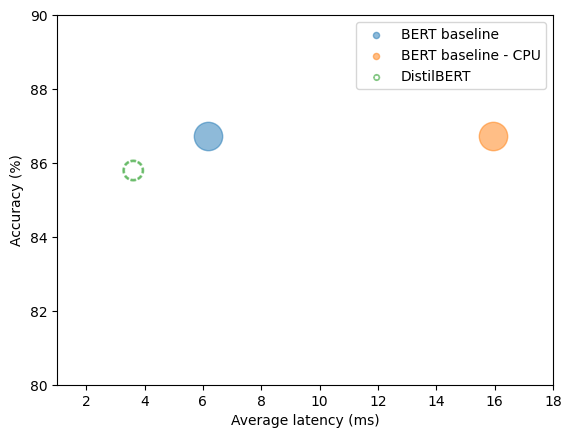

In [37]:
# Plot the latency vs accuracy with the radius being the size of the model on disk
plot_metrics(perf_metrics, "DistilBERT")

## Now let's try quantization

At this time (November 2022), torch doesn't support quantization on the gpu. It is coming. <br>
It is still instructive to compare the sizes and also notice how close in speed it is to the gpu version of BERT

The basic idea behind quantization is that we can “discretize” the floating-point values f in each tensor by mapping their range $[f_{max}, f_{min}]$ into a smaller one $[q_{max}, q_{min}]$ of fixed-point numbers , and linearly distributing all values in between. 

One of the main reasons why transformers (and deep neural networks more generally) are prime candidates for quantization is that the weights and activations tend to take values in relatively small ranges. This means we don’t have to squeeze the whole range of possible FP32 numbers into, say, the $2^8 = 256$  numbers represented by INT8. To see this, let’s pick out one of the attention weight matrices from our distilled model and plot the frequency distribution of the values:

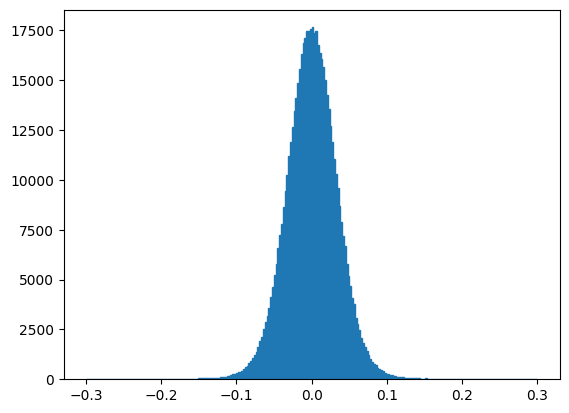

In [38]:
state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.cpu().flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

The values of the weights are distributed mostly in the range $[-0.1, 0.1]$ <br>
We can quantize this tensor as a signed 8-bit integer with the range $[-128, 127]$
We keep the zero point at zero (might need to be shifted in some cases) and calculate the scaling factor

In [39]:
zero_point = 0
qmin = -128
qmax = 127
scale = (weights.max() - weights.min()) / (qmax - qmin)
scale

tensor(0.0053, device='cuda:0')

The quantization is done by dividing all the weights by the scaling factor and shifting to the zero point and then clamping the result into the range $[q_{min}, q_{max}]$. The result is then rounded to the nearest integer value and then cast into an 8 bit number.

In [40]:
qweights = (weights / scale + zero_point).clamp(-128, 127).round()
qweights

tensor([[ -5.,  -8.,   0.,  ...,  -6.,  -4.,   8.],
        [  8.,   3.,   1.,  ...,  -4.,   7.,   0.],
        [ -9.,  -5.,   5.,  ...,   0.,   6.,  -3.],
        ...,
        [  5.,   0.,  12.,  ...,  -0.,   6.,  -1.],
        [  0.,  -2., -12.,  ...,  12.,  -8., -13.],
        [-13.,  -1.,  -9.,  ...,   8.,   2.,  -2.]], device='cuda:0')

This is all simplified by the torch function quantize_per_tensor

In [41]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   5,  ...,   0,   6,  -3],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -8, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -2]], device='cuda:0',
       dtype=torch.int8)

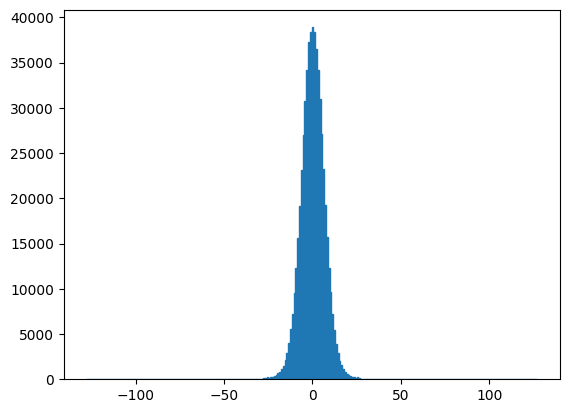

In [42]:
# Now let's plot the quantized_weights and see what it looks like
plt.hist(qweights.cpu().flatten().numpy(), bins=250, range=(-128,127), edgecolor="C0")
plt.show()

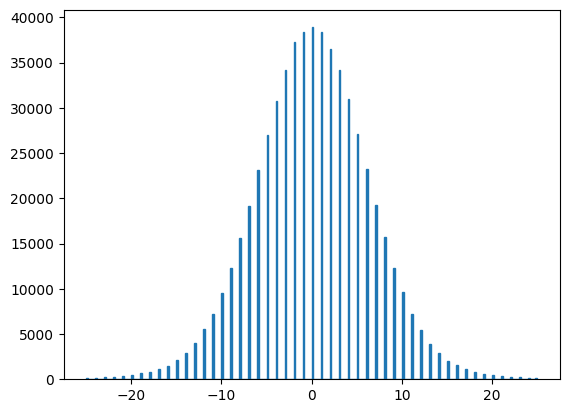

In [43]:
# Let's zoom in
plt.hist(qweights.cpu().flatten().numpy(), bins=250, range=(-25,25), edgecolor="C0")
plt.show()

The rounding performed in the quantization means that some weight values aren't represented or won't be expressed. <br>
This can affect our accuracy, but it may not because the weight differences still cause the activation functions to fire appropriately.

<img alt="Mapping floating-point numbers to 8-bit integers" width="800" caption="Quantizing floating-point numbers as unsigned 8-bit integers (courtesy of Manas Sahni)" src="notebooks/images/chapter08_fp32-to-int8.png" id="fp32toint8"/>

Consider the speed and storage size differences using the weights vs the quantized weights

In [44]:
%%time
weights @ weights

CPU times: user 448 µs, sys: 7 µs, total: 455 µs
Wall time: 306 µs


tensor([[-0.0176,  0.0078,  0.0203,  ...,  0.0258,  0.0423, -0.0118],
        [-0.0662, -0.0078,  0.0096,  ...,  0.0218, -0.0207, -0.0131],
        [-0.0007,  0.0154,  0.0218,  ..., -0.0157, -0.0169, -0.0054],
        ...,
        [-0.0309,  0.0175,  0.0083,  ...,  0.0431,  0.0583,  0.0576],
        [-0.0068,  0.0433,  0.0092,  ..., -0.0162, -0.0385, -0.0029],
        [-0.0360, -0.0092, -0.0173,  ..., -0.0103,  0.0026, -0.0042]],
       device='cuda:0')

In [45]:
from torch.nn.quantized import QFunctional

In [46]:
%%time
qweights @ qweights

CPU times: user 104 µs, sys: 2 µs, total: 106 µs
Wall time: 133 µs


tensor([[ -584.,   247.,   736.,  ...,   985.,  1486.,  -350.],
        [-2359.,  -339.,   452.,  ...,   913.,  -788.,  -620.],
        [    5.,   609.,   766.,  ...,  -532.,  -569.,  -131.],
        ...,
        [-1069.,   595.,   300.,  ...,  1522.,  2132.,  1916.],
        [ -268.,  1532.,   306.,  ...,  -523., -1363.,    86.],
        [-1241.,  -289.,  -638.,  ...,  -355.,    16.,  -185.]],
       device='cuda:0')

What about the size difference?

In [47]:
import sys

print("Size of weights: ", sys.getsizeof(weights.storage()))
print("Size of quantized_weights: ", sys.getsizeof(quantized_weights.storage()))

Size of weights:  2359344
Size of quantized_weights:  589872


That is a dramatic difference in storage size and speed

### Let's quantize our model

For a full-scale transformer, the compression rate and overall performance depend on which layers are quantized. Changing the precision for all computations introduces disturbances at each point in the model which can compound and affect the model's overall performance. We can restrict our quantization to particular layer types using the quantize_dynamic function. With dynamic quantization, nothing is changed during training. During inference, the weights of the model are converted just ahead of inference time. Thus the matrix multiplications needed for those layers are calculated with optimized functions for smaller integer data types (Note: There are many more integer math units on GPUs than floating point math units). The dynamic conversion can be a performance bottleneck, but is more flexible than a static quantization.

We will quantize only the linear layers

In [48]:
from torch.quantization import quantize_dynamic

model_ckpt = finetuned_ckpt
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file distilbert-base-uncased-finetuned-clinc/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
    "15": "what_are_your_hobbies",
    "16": "order",
    "17": "jump_start",
    "18": "schedule_meetin

In [49]:
pipe = pipeline("text-classification", model=model_quantized, tokenizer=tokenizer)

In [50]:
%%time
optim_type = "Distillation + quantization - CPU only"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.39
Average latency (ms) - 6.61 +\- 0.15
Accuracy on test set - 0.860
CPU times: user 6min 17s, sys: 562 ms, total: 6min 17s
Wall time: 38.1 s


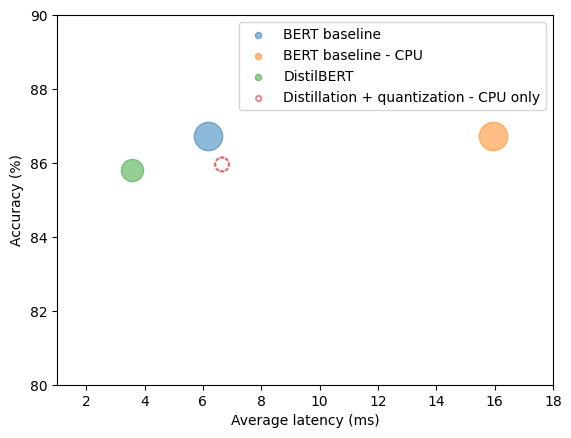

In [51]:
# Plot the latency vs accuracy with the radius being the size of the model on disk
plot_metrics(perf_metrics, optim_type)

The quantized model is half the size of the distilled version! <br>
The quantized model runing on the CPU only is almost as fast as the BERT baseline running on the GPU!

## Let's try ONNX

First, we need to convert the distilled model to the ONNX format using convert_graph_to_onnx.convert(). ONNX runs using the OpenMP environment so we need to set the OMP environment variables.

In [52]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [53]:
from transformers.convert_graph_to_onnx import convert

model_ckpt = "distilbert-base-uncased-finetuned-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

/usr/local/lib/python3.8/dist-packages/transformers/convert_graph_to_onnx.py:380: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  warnings.warn(
loading configuration file distilbert-base-uncased-finetuned-clinc/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
    "15": "what_are_your_hobbies

ONNX opset version set to: 12
Loading pipeline (model: distilbert-base-uncased-finetuned-clinc, tokenizer: PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased-finetuned-clinc', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}))


All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-clinc.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
/usr/local/lib/python3.8/dist-packages/transformers/models/distilbert/modeling_distilbert.py:213: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


Creating folder onnx
Using framework PyTorch: 1.13.0+cu116
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


Now that we have our model saved, we need to create an InferenceSession instance to feed inputs to the model:

In [57]:
!pip install onnx onnxruntime

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 54.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 31.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.6/532.6 KB 40.0 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to su

In [58]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession, SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [59]:
onnx_model = create_model_for_provider(onnx_model_path)

Try running one through and see how it does

In [60]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

Now we can get the predicted numerical label and convert it to the predicted category using the intents variable from earlier.

In [65]:
intents.int2str(int(np.argmax(logits_onnx)))

'translate'

In [66]:
clinc["test"][:1]

{'text': ['how would you say fly in italian'], 'intent': [61]}

The ONNX model is not compatible with the text-classification pipeline, so we’ll create our own class that mimics the core behavior:

In [67]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

We can then test this on our simple query to see if we recover the car_rental intent:

In [68]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.55716974}]

Our current PerformanceBenchmark class won't work for our ONNX model because the size can't be calculated using
torch.save(). We have already saved the model when we created it so it is already on the disk.

We will simply inherit from our PerformanceBenchmark class and override the compute_size() method

In [69]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

Now let's see how it performs

In [70]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.98
Average latency (ms) - 16.50 +\- 0.77
Accuracy on test set - 0.858


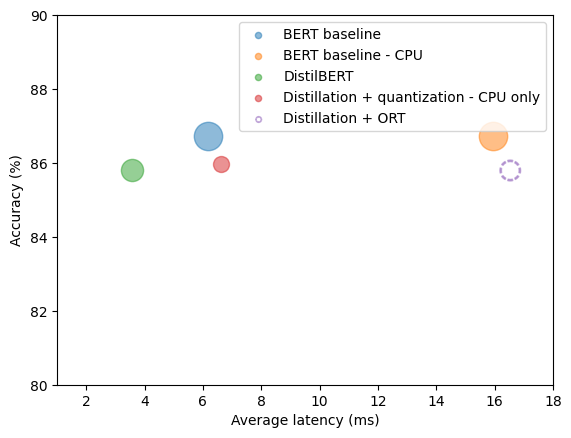

In [71]:
plot_metrics(perf_metrics, optim_type)

### Quantization in ONNX

The ONNX Runtime (ORT) also offers 3 different ways to quantize: dynamic, static, and quantization-aware training. 
We will apply dynamic quantization as we did with PyTorch.

In [72]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.5/attention/MatMul]
Ignore MatM

Now let's see how our ONNX quantized model does.

In [73]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)

In [74]:
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 64.33
Average latency (ms) - 6.47 +\- 0.19
Accuracy on test set - 0.856


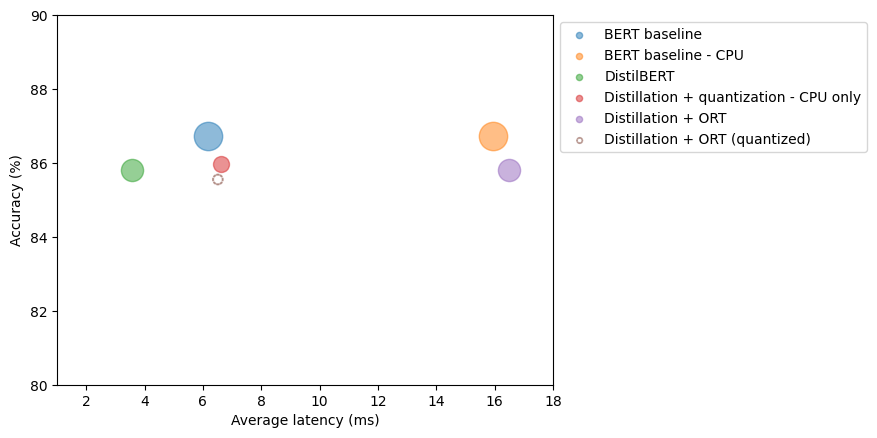

In [75]:
plot_metrics(perf_metrics, optim_type)

Notice the size and speed improvements. PyTorch only optimizes the nn.Linear modules, while ONNX quantizes the embedding layer as well. 

https://www.codeproject.com/Articles/5286799/Converting-an-ONNX-Object-Detection-Model-to-iOS-C